In [8]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
from PIL import ImageFilter
# from tensorflow.python import keras
from tensorflow import keras
from tensorflow.keras.models import load_model
# import tensorflow_hub as hub
# from tensorflow.keras.applications import EfficientNetB4, MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import *

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import os

2023-05-03 09:43:40.223568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')
import warnings
warnings.filterwarnings('ignore')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


2023-05-03 09:43:42.586100: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-03 09:43:42.587403: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-03 09:43:42.746702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-03 09:43:42.746737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-03 09:43:42.748461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-03 09:43:42.748515: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [14]:
paraguayDR_path = './datasets/paraguayDR/'
paraguayDR_path_train_test = paraguayDR_path+"images/"
paraguay_csv = paraguayDR_path + "ImageNames.csv"

In [18]:
# paraguayDR_path_train_test
!ls ./datasets/paraguayDR/images|wc

   1438    1438   11836


In [25]:
# Define the paths to the image directory and the CSV file
train_image_dir: str = paraguayDR_path_train_test
csv_file = paraguay_csv #kaggle_csv #messidor_csv
# Loading the dataset
df = pd.read_csv(csv_file)

# #uncomment for idrid data
df = df[['Image']]
print(df.shape)
df['Image'] = df['Image'].astype(str)
df.rename(columns={'Image': 'img_name'}, inplace=True)
# df.dropna(how='all', inplace = True)
# df_shuffled = df.sample(frac=1, random_state=1)
# df = df_shuffled.copy()
print(df.shape)
test_datagen = ImageDataGenerator(rescale=None)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_image_dir,
    x_col="img_name",
    y_col=None,
    target_size=(512, 512),
    batch_size=32,
    shuffle=False,
    class_mode=None
    )

(1437, 1)
(1437, 1)
Found 1437 validated image filenames.


In [26]:
def aggregate_labels(y_true,y_pred):
    original_labels = [0, 1, 2, 3, 4] # original labels
    new_labels = [0, 1] # new labels
    label_map = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1} # mapping from original labels to new labels
    new_y_true = np.zeros((y_true.shape[0], len(new_labels)))
    new_y_pred = np.zeros((y_pred.shape[0], len(new_labels)))
    for i, row in enumerate(y_true):
        for j, val in enumerate(row):
            if val == 1:
                new_label = label_map[original_labels[j]]
                new_y_true[i, new_label] = 1           
    for i, row in enumerate(y_pred):
        for j, val in enumerate(row):
            new_label = label_map[original_labels[j]]
            new_y_pred[i, new_label] += val
#     print("original predictions:\n", y_pred)        
#     print("Aggregated predictions:\n", new_y_pred)
    return new_y_true, new_y_pred

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, cohen_kappa_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
def plot_model(model_name,y_true_original,y_pred_original):
#     y_true = tf.keras.utils.to_categorical(test_generator.classes)
#     y_pred = model.predict_generator(test_generator)
    y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
    print(np.shape(y_true),np.shape(y_pred))
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
#         print(type(fpr[i]),len(fpr[i]),fpr[i])
#         print(np.shape(roc_auc[i]))
        print(roc_auc[i])
        print('_______________________')
#         print(type(tpr[i]),len(tpr[i]),tpr[i])
    print(len(y_true.ravel()))
    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(2):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 2
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    aurocs = roc_auc_score(y_true, y_pred, multi_class = 'ovr', average = 'macro')
    print("AUROC score for model "+str(model_name)+":", aurocs)
    # Plot ROC curves for each class and micro/macro-average
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
             lw=lw, label='micro-average ROC curve (AUC = %0.2f)' % roc_auc["micro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy',
             lw=lw, label='macro-average ROC curve (AUC = %0.2f)' % roc_auc["macro"])
    colors = ['blue', 'green', 'red', 'cyan', 'magenta']
    for i, color in zip(range(2), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class %d (AUC = %0.2f)' % (i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_model_binary(model_name,y_true_original,y_pred_original):
    
    y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
#     print(np.shape(y_true),np.shape(y_pred))
    
    #saving data to verify manually
    l1 = list(y_true[:,0].T)
    l2 = list(y_true[:,1].T)
    l3 = list(y_pred[:,0].T)
    l4 = list(y_pred[:,1].T)
    l5 = list(np.where(y_pred[:,1].T>0.5,1,0))
    dictionary = {'True 0':l1,'True 1':l2,'Predicted 0':l3,'Predicted 1':l4,'Predicted_Onehot':l5}
#     pd.DataFrame(dictionary).to_csv('results.csv', index = False, header = True)
    
    acc_score = accuracy_score(y_true[:,1],np.where(y_pred[:,1]<=0.5,0,1))
    print('Accuracy:',acc_score)
    
    kappa_score = cohen_kappa_score(np.argmax(y_true_original,axis=1 ), np.argmax(y_pred_original,axis=1), weights='quadratic')
    print('Quadratic Weighted Kappa:', kappa_score)
    
    # Compute ROC curve and AUC for each class
    # calculate the false positive rate, true positive rate and thresholds using roc_curve
    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    # calculate the AUC score using roc_auc_score
    auc_score = roc_auc_score(y_true[:, 1], y_pred[:, 1])
    print("AUROC score for model "+str(model_name)+":", auc_score)

    # plot the ROC curve
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlabel('FPR ( or 1 minus Specificity)')
    plt.ylabel('TPR (or Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
def plot_conf_matrix(model_name, y_true_original,y_pred_original):
    
    y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
    cm = confusion_matrix(y_true[:,1], np.where(y_pred[:,1]<=0.5,0,1))
    # Plot the confusion matrix
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(i, j, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Confusion Matrix for model:'+model_name)
    plt.show()

In [22]:
# modelmobile = MobileNetV3Small(input_shape=(512, 512, 3),include_top=False,weights='imagenet',pooling='avg',alpha=1.0,minimalistic=True)
# modelmobile.summary()

In [24]:
# plot_model_binary(models[0],y_true,y_pred)
# plot_conf_matrix(models[0],y_true,y_pred)
# models[1:2]

In [28]:
# # models = ['MobNetv3small_0.75_224','EffNet_B4_imagenet']#
# for model in models[1:2]:
# #     m = load_model('./'+model+'.h5')
#     m = load_model('./'+'ensemble_model_b4b5b6b7_v1'+'.h5')
#     y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
#     y_pred_model = m.predict_generator(test_generator)
#     plot_model_binary(model,y_true_model,y_pred_model)
#     plot_conf_matrix(model,y_true_model,y_pred_model)


model = load_model('./'+'teacher_ensemble_b4b5b6'+'.h5')
# y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
y_pred_model = model.predict_generator(test_generator)
y_pred_labels = np.argmax(y_pred_model,axis=1)

2023-05-03 10:28:05.619376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 10:28:05.622308: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-03 10:28:05.623110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-03 10:28:05.623173: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-03 10:28:05.623199: I tensorflow/stream_executor/

2023-05-03 10:28:24.897083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-03 10:28:24.917928: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-05-03 10:28:35.088951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-03 10:28:35.570678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-03 10:28:36.852288: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-03 10:28:36.956017: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [33]:
df[['class_0_prob', 'class_1_prob', 'class_2_prob', 'class_3_prob', 'class_4_prob']] = y_pred_model
df['Label_assigned'] = y_pred_labels
df.to_csv('./datasets/paraguayDR/EnsembleLabels.csv', header=True, index=False)

### Calculating Ensemble Performance Here

### A. Performance of Saved ensemble v2 b4b5b6b7

In [28]:
# # Load the ensemble model for prediction later
# loaded_ensemble_model = load_model('teacher_ensemble.h5')
# # loaded_ensemble_model = ensemble_model
# # Use the loaded ensemble model to make predictions
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_ensemble = loaded_ensemble_model.predict_generator(test_generator)
# plot_model_binary('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)
# plot_conf_matrix('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)

### B. Performance of Saved ensemble v3 b4b5b6

2023-05-02 12:50:53.778097: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 12:50:53.781877: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-02 12:50:53.782634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-02 12:50:53.782692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 12:50:53.782714: I tensorflow/stream_executor/

2023-05-02 12:51:07.336042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-02 12:51:07.354060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-05-02 12:51:15.749585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-02 12:51:15.972671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-02 12:51:17.189929: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-02 12:51:17.284845: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Accuracy: 0.937046004842615
Quadratic Weighted Kappa: 0.860661703835833
AUROC score for model Teacher_ensemble: 0.9925913854485284


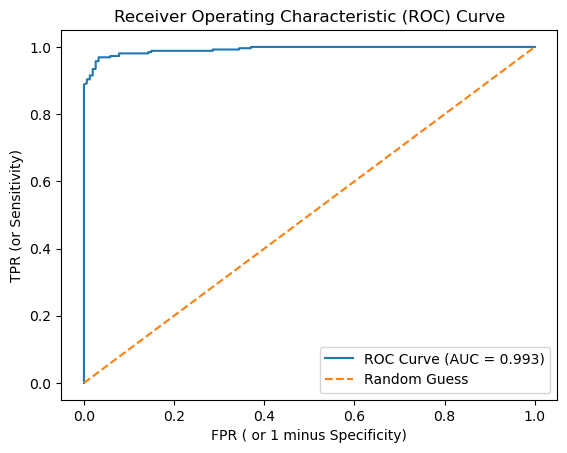

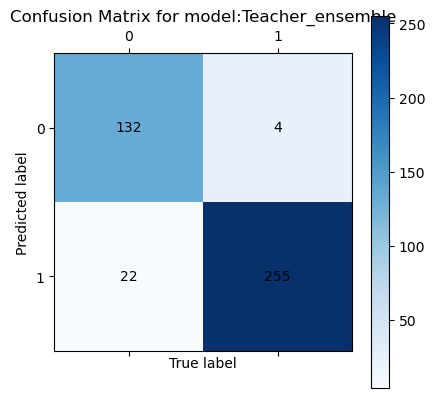

In [29]:
# Load the ensemble model for prediction later
loaded_ensemble_model = load_model('teacher_ensemble_b4b5b6.h5')
# Use the loaded ensemble model to make predictions
y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
y_pred_ensemble = loaded_ensemble_model.predict_generator(test_generator)
plot_model_binary('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)
plot_conf_matrix('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)

### C. Performance of ensemble on the go from the individual models loaded below

In [ ]:
# mods=['EffNet_B5_imagenet_norescale_sameastfmodel','EffNet_B6_imagenet_norescale_sameastfmodel',
#  'EffNet_B7_imagenet_norescale_sameastfmodel','EffNet_B4_imagenet_norescale_sameastfmodel']
# model1 = load_model('./'+mods[0]+'.h5')
# model2 = load_model('./'+mods[1]+'.h5')
# model3 = load_model('./'+mods[2]+'.h5')
# model4 = load_model('./'+mods[3]+'.h5')
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# all_models=[model1,model2,model3,model4]
# y_pred_ensemble=[]
# for model in all_models:
#         y_pred_ensemble.append(model.predict_generator(test_generator))

In [ ]:
# y_pred_ensemble = np.mean(y_pred_ensemble, axis=0)
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# plot_model_binary('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)
# plot_conf_matrix('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)

In [ ]:
# x = train_generator.next()

In [ ]:
# x[0].shape

In [ ]:
# m.predict(x[0]).argmax(1)

In [ ]:
# plt.imshow(x[0][10])